In [14]:
import os
import numpy as np
import pandas as pd
import scipy
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from gc import collect
from matplotlib.ticker import MaxNLocator
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import clone
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, make_scorer, r2_score, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler


In [7]:
def get_feats(mode="train"):

    feats = pd.read_excel(
        f"../Data/widsdatathon2025/{mode}/{mode}_QUANTITATIVE_METADATA.xlsx"
    )

    if mode == "TRAIN":
        cate = pd.read_excel(
            f"../Data/widsdatathon2025/{mode}/{mode}_CATEGORICAL_METADATA.xlsx"
        )
    else:
        cate = pd.read_excel(f"../Data/widsdatathon2025/{mode}/{mode}_CATEGORICAL.xlsx")

    feats = feats.merge(cate, on="participant_id", how="left")

    func = pd.read_csv(
        f"../Data/widsdatathon2025/{mode}/{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv"
    )
    feats = feats.merge(func, on="participant_id", how="left")

    if mode == "TRAIN":
        solution = pd.read_excel(
            "../Data/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"
        )
        feats = feats.merge(solution, on="participant_id", how="left")

    return feats


train = get_feats(mode="TRAIN")
test = get_feats(mode="TEST")
sub = pd.read_excel("../Data/widsdatathon2025/SAMPLE_SUBMISSION.xlsx")
y = pd.read_excel(f"../Data/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")

In [8]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
targets = ['ADHD_Outcome','Sex_F']
features = test.columns

In [9]:
def check_for_nulls(df):
  if df.isnull().any().any():
    print("The DataFrame contains null values.")
  else:
    print("The DataFrame does not contain null values.")

In [10]:
check_for_nulls(train)
check_for_nulls(test)
print(f'Train: {train.shape}, Test: {test.shape}')

The DataFrame contains null values.
The DataFrame contains null values.
Train: (1213, 19929), Test: (304, 19927)


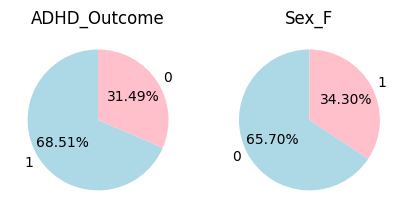

In [11]:
fig, axs = plt.subplots(1,2, figsize=(5,3))

for col, ax in zip(y.drop('participant_id',axis=1), axs):    
    counts = y[col].value_counts()
    ax.pie(counts, labels=counts.index, 
           autopct='%1.2f%%', 
           startangle=90, colors = ["lightblue", "pink"])
    ax.set_title(f'{col}')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(targets,axis=1), 
                                                    y[targets], 
                                                    test_size=0.2, 
                                                    random_state=42)
log_features = [f for f in features if (train[f] >= 0).all() and scipy.stats.skew(train[f]) > 0]


## **Models**

### **Ridge Classifier**

In [ ]:
model = MultiOutputClassifier(make_pipeline(
                        
                              ColumnTransformer([('imputer',SimpleImputer(),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                              
                            MinMaxScaler(),    
                              
                            RidgeClassifier(alpha=100)))
model.fit(X_train,y_train)
y_pred = model.predict(X_test)



sensitivity = recall_score(y_test, y_pred, average=None)  # Per label sensitivity

specificities = []
for i in range(y_test.shape[1]):  # Loop over each label
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])  # Get confusion matrix for each label
    if cm.shape == (2, 2):  # Ensure it's a binary classification confusion matrix
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero
    else:
        specificity = 0  # Default in case of single-class predictions
    specificities.append(specificity)

# Print Results
print('\nRidge Classifier Results:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall (Sensitivity):', sensitivity.mean())  # Mean sensitivity across labels
print('Specificity:', np.mean(specificities))  # Mean specificity across labels
print('F1 Score:', f1_score(y_test, y_pred, average='micro'))


Ridge Classifier Results:
Accuracy: 0.6049382716049383
Recall (Sensitivity): 0.6207084893882646
Specificity: 0.5978407557354926
F1 Score: 0.7735470941883767


### **Logistic Regression**

In [15]:
model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    MinMaxScaler(),
    LogisticRegression(max_iter=1000)
))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


sensitivity = recall_score(y_test, y_pred, average=None)  # Per label sensitivity

specificities = []
for i in range(y_test.shape[1]):  # Loop over each label
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])  # Get confusion matrix for each label
    if cm.shape == (2, 2):  # Ensure it's a binary classification confusion matrix
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero
    else:
        specificity = 0  # Default in case of single-class predictions
    specificities.append(specificity)

# Print Results
print('\nLogistic Regression Results:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall (Sensitivity):', sensitivity.mean())  # Mean sensitivity across labels
print('Specificity:', np.mean(specificities))  # Mean specificity across labels
print('F1 Score:', f1_score(y_test, y_pred, average='micro'))



Logistic Regression Results:
Accuracy: 0.6131687242798354
Recall (Sensitivity): 0.6220349563046192
Specificity: 0.6161493477282951
F1 Score: 0.7757575757575758


In [ ]:
# y_pred_test = model.predict(test)

In [ ]:
# y_pred_test.shape

(304, 2)

In [ ]:
# import pandas as pd
# import numpy as np

# # Assuming 'test' DataFrame contains a 'participant_id' column
# df = test.reset_index()[["participant_id"]].copy()  # Extract participant_id column

# # Convert NumPy array to DataFrame
# numpy_df = pd.DataFrame(y_pred_test, columns=["ADHD_Outcome", "Sex_F"])

# # Concatenate along columns
# result_df = pd.concat([df, numpy_df], axis=1)

# # Save to CSV
# result_df.to_csv("output.csv", index=False)

# print("CSV file saved as output.csv")


CSV file saved as output.csv


### **Random Forest**

In [24]:
rf_model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest Classifier
))

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


sensitivity = recall_score(y_test, y_pred, average=None)  # Per label sensitivity

specificities = []
for i in range(y_test.shape[1]):  # Loop over each label
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])  # Get confusion matrix for each label
    if cm.shape == (2, 2):  # Ensure it's a binary classification confusion matrix
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero
    else:
        specificity = 0  # Default in case of single-class predictions
    specificities.append(specificity)

# Print Results
print('\nRandom Forest Results:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall (Sensitivity):', sensitivity.mean())  # Mean sensitivity across labels
print('Specificity:', np.mean(specificities))  # Mean specificity across labels
print('F1 Score:', f1_score(y_test, y_pred, average='micro'))



Random Forest Results:
Accuracy: 0.5349794238683128
Recall (Sensitivity): 0.5082709113607989
Specificity: 0.5190733243364822
F1 Score: 0.7221095334685599


### **Kernel SVM**

In [25]:
svm_model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    MinMaxScaler(),
    SVC(kernel='rbf', probability=True, random_state=42)  
))

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

sensitivity = recall_score(y_test, y_pred, average=None) 

specificities = []
for i in range(y_test.shape[1]):  
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])  
    if cm.shape == (2, 2):  
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    else:
        specificity = 0  
    specificities.append(specificity)

print('\nKernel SVM Results:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall (Sensitivity):', sensitivity.mean())  # Mean sensitivity across labels
print('Specificity:', np.mean(specificities))  # Mean specificity across labels
print('F1 Score:', f1_score(y_test, y_pred, average='micro'))



Kernel SVM Results:
Accuracy: 0.551440329218107
Recall (Sensitivity): 0.49719101123595505
Specificity: 0.5230769230769231
F1 Score: 0.7239263803680982


In [28]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Define the XGBoost-based model
xgb_model = MultiOutputClassifier(make_pipeline(
    ColumnTransformer([('imputer', SimpleImputer(), features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False).set_output(transform='pandas'),
    ColumnTransformer([('log', FunctionTransformer(np.log1p), log_features)],
                      remainder='passthrough'),
    MinMaxScaler(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
))

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate sensitivity (recall)
sensitivity = recall_score(y_test, y_pred, average=None)

# Calculate specificity for each label
specificities = []
for i in range(y_test.shape[1]):  
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])  
    if cm.shape == (2, 2):  
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    else:
        specificity = 0  
    specificities.append(specificity)

# Print evaluation metrics
print('\nXGBoost Results:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall (Sensitivity):', sensitivity.mean())  # Mean sensitivity across labels
print('Specificity:', np.mean(specificities))  # Mean specificity across labels
print('F1 Score:', f1_score(y_test, y_pred, average='micro'))


/Users/amirsabbaghziarani/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/amirsabbaghziarani/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Accuracy: 0.5349794238683128
Recall (Sensitivity): 0.5132646691635455
Specificity: 0.7012145748987855
F1 Score: 0.717948717948718


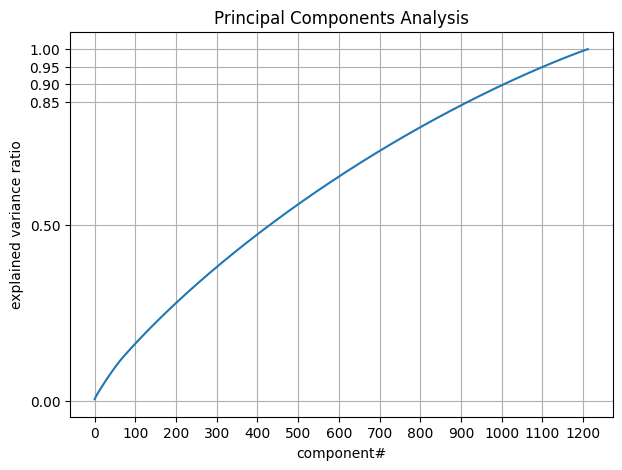

In [26]:
pca = make_pipeline(SimpleImputer(),StandardScaler(),PCA())
pca.fit(train[test.columns])
plt.figure(figsize=(7,5))
plt.plot(pca[-1].explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks([0,0.5,0.85,0.90,0.95,1])
plt.xticks(range(0,1300,100))
plt.grid()
plt.show()

/Users/amirsabbaghziarani/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/amirsabbaghziarani/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


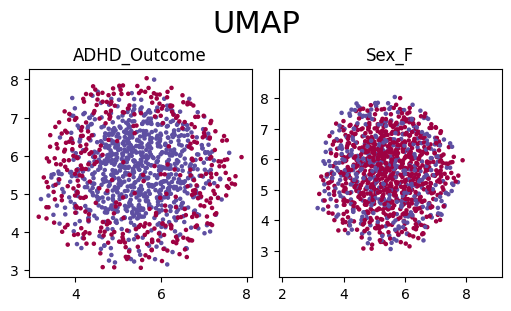

In [27]:
pipe = make_pipeline(SimpleImputer(),MinMaxScaler())
reducer = umap.UMAP()
x_scaler = pipe.fit_transform(train[features])
reducer.fit(x_scaler)
_, axs = plt.subplots(1,2, figsize=(5,3), constrained_layout=True)
embedding = reducer.transform(x_scaler)
for t,ax in zip(targets,axs.ravel()):    
    ax.scatter(embedding[:, 0], embedding[:, 1], c=y[t], cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    ax.set_title(f'{t}')
plt.suptitle('UMAP',fontsize=22);